# Quality control - BSRN checks

The most commonly applied quality control (QC) checks are the [BSRN recommended QC tests V2](https://bsrn.awi.de/fileadmin/user_upload/bsrn.awi.de/Publications/BSRN_recommended_QC_tests_V2.pdf) (these are the QC checks introduced in the lecture notes). The advantage of such automatic checks is that they are easy to implement, applicable to stations in most climates, and do not require extensive experience of the analyst.

In this exercise, you will learn how to apply the BSRN quality to solar irradiance measurements.

In [1]:
# Install pvlib on Google Colab as this is not a standard package.
# !pip install pvlib

In [2]:
import pvlib  # library for PV and solar calculations
import pandas as pd  # library for data analysis
import matplotlib.pyplot as plt  # library for plotting
import numpy as np  # library for math and linear algebra

## Step 1: Read dataset
The example dataset contains data of GHI, DHI, and DNI from DTU's Solar Radiation Monitoring Station for August 2025.

Note, a number of severe but plausible errors have been added to the dataset!

In [22]:
file_url = 'https://raw.githubusercontent.com/AdamRJensen/solar-resource-course/refs/heads/main/data/example_dataset_with_errors.csv'

data = pd.read_csv(file_url, index_col=[0], parse_dates=[0])

data.head()

,SHP1_185163_DNI_Wm2,SMP22_200060_DHI_Wm2,SMP22_200057_GHI_Wm2,solar_zenith,solar_azimuth
Time,,,,,
2025-08-01 00:00:00+00:00,-1.302,-0.800,-0.7,105.634,10.791
2025-08-01 00:01:00+00:00,-1.365,-0.768,-0.7,105.607,11.036
2025-08-01 00:02:00+00:00,-1.377,-0.748,-0.7,105.580,11.281
2025-08-01 00:03:00+00:00,-1.300,-0.705,-0.7,105.553,11.527
2025-08-01 00:04:00+00:00,-1.300,-0.763,-0.7,105.524,11.772


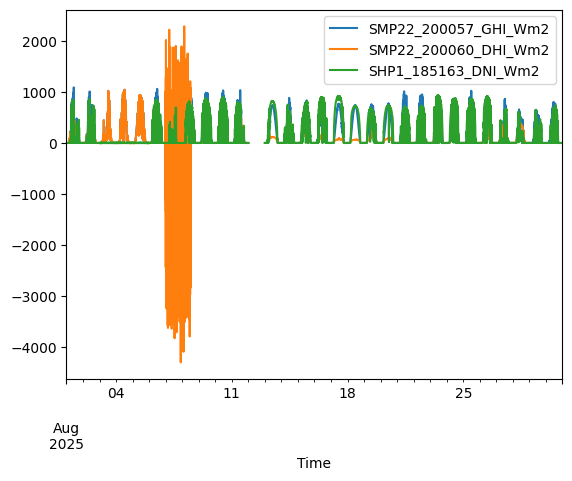

In [24]:
data[['SMP22_200057_GHI_Wm2', 'SMP22_200060_DHI_Wm2', 'SHP1_185163_DNI_Wm2']].plot();

## Step 2: Calculate extraterrestrial irradiance

Use the pvlib-python function [``pvlib.irradiance.get_extra_radiation``](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.irradiance.get_extra_radiation.html) to calculate extraterrestrial irradiance.

*Hint: for the ``datetime_or_doy`` input to the function you can simply use ``data.index``.*

In [4]:
# write your code here
data['ETR'] = pvlib.irradiance.get_extra_radiation(data.index)

## Step 3: Calculate the BSRN limits

In this exercise, we will be using the **extremely rare limits**. The equations for the limits can be found in the lecture note for Lesson 3.

The first step is to calculate the upper limits. We don't need to calculate the lower limits, as they are simply a fixed value.

In [5]:
# Write the code for the upper limits:

# data['ghi_upper_limit'] =

In [6]:
#### SOLUTION ####
data['ghi_upper_limit'] = 1.2 * data['ETR'] * np.cos(np.deg2rad(data['solar_zenith'].clip(upper=90)))**1.2 + 50
data['dhi_upper_limit'] = 0.75 * data['ETR'] * np.cos(np.deg2rad(data['solar_zenith'].clip(upper=90)))**1.2 + 30
data['dni_upper_limit'] = 0.95 * data['ETR'] * np.cos(np.deg2rad(data['solar_zenith'].clip(upper=90)))**0.2 + 10

## Step 4: Calculate limit flags
Once the limits have been derived, we can now compute the limit flags for each component. Remember that a flag should be True (1) if the measurement is suspicious or False (0) if the measurement seems plausible.

*Hint: Since we are comparing two conditions (whether the irradiance is above or below a threshold), we need to use either the ``&`` for AND if both conditions need to be true or   ``|`` for OR if only one condition needs to be true.*

In [7]:
# data['ghi_limit_flag'] = (data['SMP22_200057_GHI_Wm2'] < -2) | (data['ghi'] > data['ghi_upper_limit'])

#### SOLUTION ####
data['ghi_limit_flag'] = (data['SMP22_200057_GHI_Wm2'] < -2) | (data['SMP22_200057_GHI_Wm2'] > data['ghi_upper_limit'])
data['dhi_limit_flag'] = (data['SMP22_200060_DHI_Wm2'] < -2) | (data['SMP22_200060_DHI_Wm2'] > data['dhi_upper_limit'])
data['dni_limit_flag'] = (data['SHP1_185163_DNI_Wm2'] < -2) | (data['SHP1_185163_DNI_Wm2'] > data['dni_upper_limit'])

## Step 5: Visualize the limit flags

To get an understanding of how much data was flagged, it's useful to plot the daily flagged fraction of data. Also, to get an idea of h

Text(0.5, 1.0, 'Nighttime')

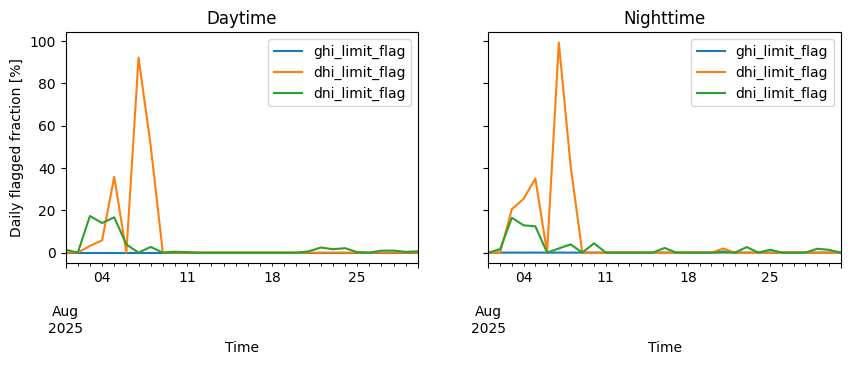

In [8]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 3))

limit_flags = ['ghi_limit_flag', 'dhi_limit_flag', 'dni_limit_flag']

data.loc[data['solar_zenith']<90, limit_flags].resample('1d').mean().multiply(100).plot(ax=axes[0], ylabel='Daily flagged fraction [%]')
data.loc[data['solar_zenith']>90, limit_flags].resample('1d').mean().multiply(100).plot(ax=axes[1], ylabel='Daily flagged fraction [%]')

axes[0].set_title('Daytime')
axes[1].set_title('Nighttime')

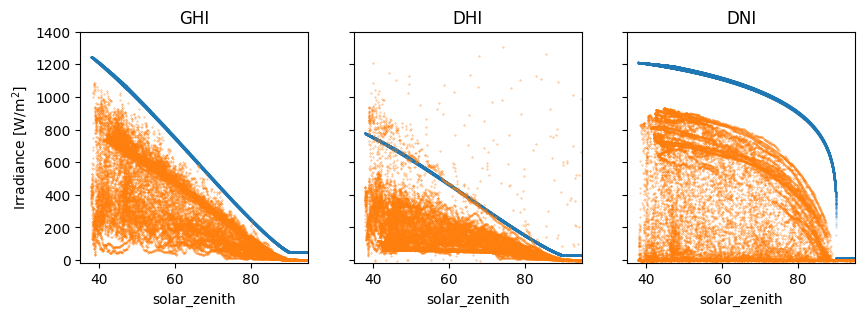

In [19]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(10, 3))

data.plot.scatter(ax=axes[0], x='solar_zenith', y='ghi_upper_limit', c='C0', s=0.1, alpha=0.4)
data.plot.scatter(ax=axes[0], x='solar_zenith', y='SMP22_200057_GHI_Wm2', c='C1', s=0.1, alpha=0.8)

data.plot.scatter(ax=axes[1], x='solar_zenith', y='dhi_upper_limit', c='C0', s=0.1, alpha=0.4)
data.plot.scatter(ax=axes[1], x='solar_zenith', y='SMP22_200060_DHI_Wm2', c='C1', s=0.1, alpha=0.8)

data.plot.scatter(ax=axes[2], x='solar_zenith', y='dni_upper_limit', c='C0', s=0.1, alpha=0.4)
data.plot.scatter(ax=axes[2], x='solar_zenith', y='SHP1_185163_DNI_Wm2', c='C1', s=0.1, alpha=0.8)

for ax, title in zip(axes, ['GHI', 'DHI', 'DNI']):
    ax.set_xlim(35, 95)
    ax.set_ylim(-15, 1400)
    ax.set_title(title)

axes[0].set_ylabel('Irradiance [W/m$^2$]')

plt.show()

## Step 5: Determine calculated GHI

For the comparison QC checks we need the calculated GHI from DHI and DNI (remember the closure equation?).

In [10]:
# Write your code here

# data['ghi_calc'] = 

#### SOLUTION ####

data['GHI_calc'] = data['SMP22_200060_DHI_Wm2'] + data['SHP1_185163_DNI_Wm2'] * np.cos(np.deg2rad(data['solar_zenith']))

## Step 6: Closure check

The most powerful QC check available is the closure check because it allows us to compare the same value (GHI) obtained from two independent sources.

In the below code cell, you should calculated the QC flag for the closure check.

*Hint: To make it easier to implement, you can calculate two flags, one for high zenith angles and one for low zenith angles.*

In [11]:
# Calculate the closure check flag

#### SOLUTION ####
data['GHI_ratio'] = (data['SMP22_200057_GHI_Wm2'] / data['GHI_calc'] - 1).abs()

high_zenith = (data['solar_zenith'] > 75) & (data['solar_zenith'] < 93)
low_zenith = data['solar_zenith'] < 75

data['closure_low_zenith_flag'] = False
data.loc[(data['GHI_ratio'] > 0.08) & (data['GHI_calc'] > 50) & low_zenith, 'closure_low_zenith_flag'] = True

data['closure_high_zenith_flag'] = False
data.loc[(data['GHI_ratio'] > 0.15) & (data['GHI_calc'] > 50) & high_zenith, 'closure_high_zenith_flag'] = True

data['closure_flag'] = data['closure_high_zenith_flag'] | data['closure_low_zenith_flag']

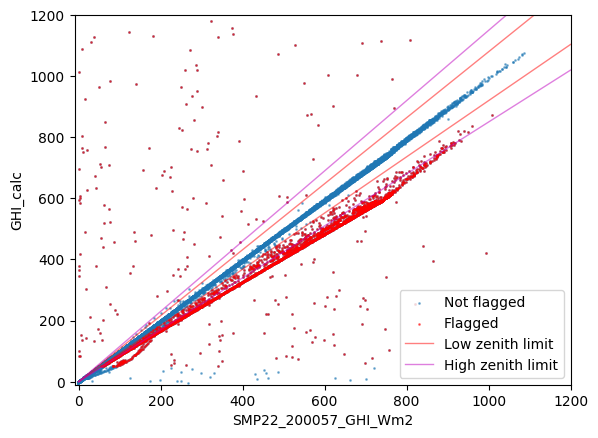

In [18]:
fig, ax = plt.subplots()

data[low_zenith | high_zenith].plot.scatter(ax=ax, x='SMP22_200057_GHI_Wm2', y='GHI_calc', s=1, alpha=0.5, label='Not flagged')
data[data['closure_flag']].plot.scatter(ax=ax, x='SMP22_200057_GHI_Wm2', y='GHI_calc', s=1, alpha=0.5, c='r', label='Flagged')

# Plot limits
ax.plot([0, 1200], [0, 1200*(1+.08)], c='r', alpha=0.5, lw=1, label='Low zenith limit')
ax.plot([0, 1200], [0, 1200*(1-.08)], c='r', alpha=0.5, lw=1)
ax.plot([0, 1200], [0, 1200*(1+.15)], c='m', alpha=0.5, lw=1, label='High zenith limit')
ax.plot([0, 1200], [0, 1200*(1-.15)], c='m', alpha=0.5, lw=1)

ax.set_xlim(-10, 1200)
ax.set_ylim(-10, 1200)

ax.legend()
plt.show()

## Step 7: Diffuse fraction check

The second BSRN comparison check assesses the diffuse fraction:

$K = DHI / GHI$

Similar to the closure check above, determine the diffuse fraction QC flag for the high and low zenith regimes.

<Axes: xlabel='SMP22_200057_GHI_Wm2', ylabel='K'>

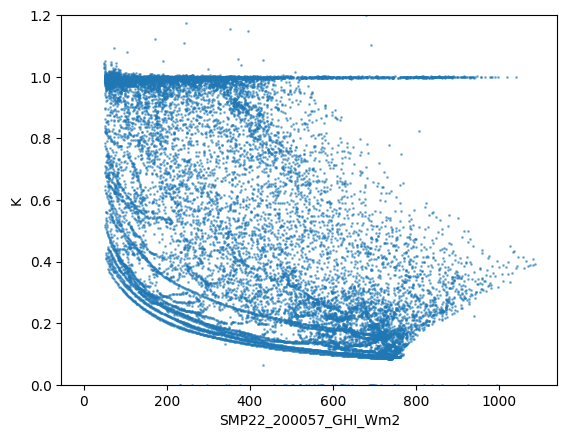

In [16]:
# Write your code here


#### SOLUTION #####
data['K'] = data['SMP22_200060_DHI_Wm2'].clip(lower=0) / data['SMP22_200057_GHI_Wm2'].clip(lower=0)

data['diffuse_ratio_low_zenith_flag'] = False
data.loc[(data['K'] > 1.05) & (data['SMP22_200057_GHI_Wm2'] > 50) & low_zenith, 'diffuse_ratio_low_zenith_flag'] = True

data['diffuse_ratio_high_zenith_flag'] = False
data.loc[(data['K'] > 1.10) & (data['SMP22_200057_GHI_Wm2'] > 50) & high_zenith, 'diffuse_ratio_high_zenith_flag'] = True

data[(data['GHI_calc']>50) & (data['solar_zenith']<93)].plot.scatter(x='SMP22_200057_GHI_Wm2', y='K', s=1, alpha=0.5, ylim=[0, 1.2])

## Step 8: Calculated statistics

In the last step, you need to calculate the percentage of flagged data for each QC flag:

<Axes: xlabel='Time'>

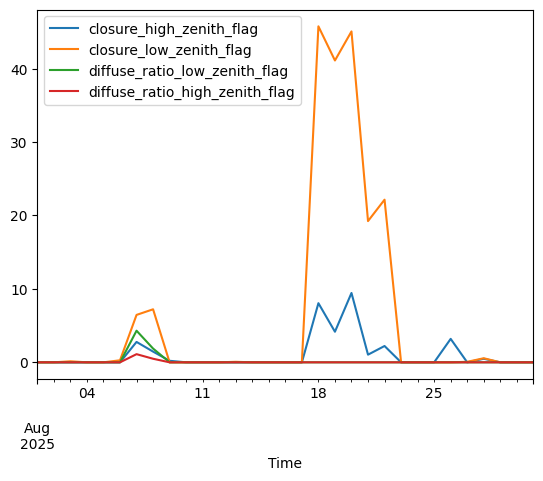

In [14]:
# Write your code here


#### SOLUTION ####

comparison_flags = ['closure_high_zenith_flag', 'closure_low_zenith_flag', 'diffuse_ratio_low_zenith_flag', 'diffuse_ratio_high_zenith_flag']

data[comparison_flags].resample('1d').mean().multiply(100).plot()

## EXTRA

You have now successfully applied the BSRN QC checks and significantly enhanced your dataset by removing potentially erroneous data.

However, to improve future data collection, it is necessary to understand what went wrong with our measurements.

Therefore, the final step is to visualize the data and figure out what went wrong. Note, 5 different errors were added to the dataset!

In [15]:
# Explore the data visually here


### Solution

- **Shading object**: There is a 15-degree shading object between 250 and 270 degrees of azimuth.
- **Stuck tracker**: The tracker was stuck during the 3rd, 4th, and 5th of August.
- **Soiling**: The pyrheliometer was soiled 20% more than the pyranometers between the 18th and 22nd of August
- **Missing data**: Data is missing during multiple periods in the dataset.
